## Importing Libraries

In [37]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import pandas as pd # DataFrame work superior to Pandas
import requests
import time

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             roc_curve, 
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

from pathlib import Path

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from sklearn.feature_selection import VarianceThreshold
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

## Pulling Data from Polygon API

In [38]:
POLYGON_API_KEY = "KrqYjA5A1KesZpHIJkJyBK3PshZTGNKL"
TICKER = "BAH"
START_DATE = "2023-01-01"
END_DATE = "2025-06-30"
WINDOW_SHORT, WINDOW_MED, WINDOW_LONG = 21, 63, 252
TEST_SIZE = 0.20  # last 20% rows as hold‑out test
BUY_THRESHOLD = 0.01  # 1% return over next month = "Buy"
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)

In [39]:
def get_polygon_data(ticker, start=START_DATE):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start}/{pd.Timestamp.today().strftime('%Y-%m-%d')}"
    params = {"adjusted":"true", "sort":"asc", "limit":50000, "apiKey":POLYGON_API_KEY}
    print(f"Requesting: {url}")
    r = requests.get(url, params=params, timeout=30)
    print("Response:", r.status_code)
    data = r.json()
    print("Response JSON:", data if len(str(data)) < 500 else str(data)[:500]+"...")

    if "results" not in data or not data["results"]:
        raise ValueError("No results returned. Check API key, ticker, or quota limits.")

    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df.rename(columns={"t":"date","o":"open","h":"high","l":"low","c":"close","v":"volume"}, inplace=True)
    return df.set_index("date")[["open","high","low","close","volume"]]

print("Downloading BAH daily bars …")
bah = get_polygon_data(TICKER)

Requesting: https://api.polygon.io/v2/aggs/ticker/BAH/range/1/day/2023-01-01/2025-07-13
Response: 200
Response JSON: {'ticker': 'BAH', 'queryCount': 500, 'resultsCount': 500, 'adjusted': True, 'results': [{'v': 557190, 'vw': 113.0343, 'o': 112.49, 'c': 113.29, 'h': 113.475, 'l': 111.8601, 't': 1689307200000, 'n': 12945}, {'v': 500141, 'vw': 114.2683, 'o': 113.29, 'c': 114.34, 'h': 114.74, 'l': 112.94, 't': 1689566400000, 'n': 11879}, {'v': 1067525.0, 'vw': 115.4363, 'o': 114.06, 'c': 115.57, 'h': 115.81, 'l': 114.06, 't': 1689652800000, 'n': 17506}, {'v': 945203, 'vw': 115.9945, 'o': 115.98, 'c': 116.04, 'h': ...


Candlestick + RSI chart …
Average RSI (14) since 2023-01-01: 50.73


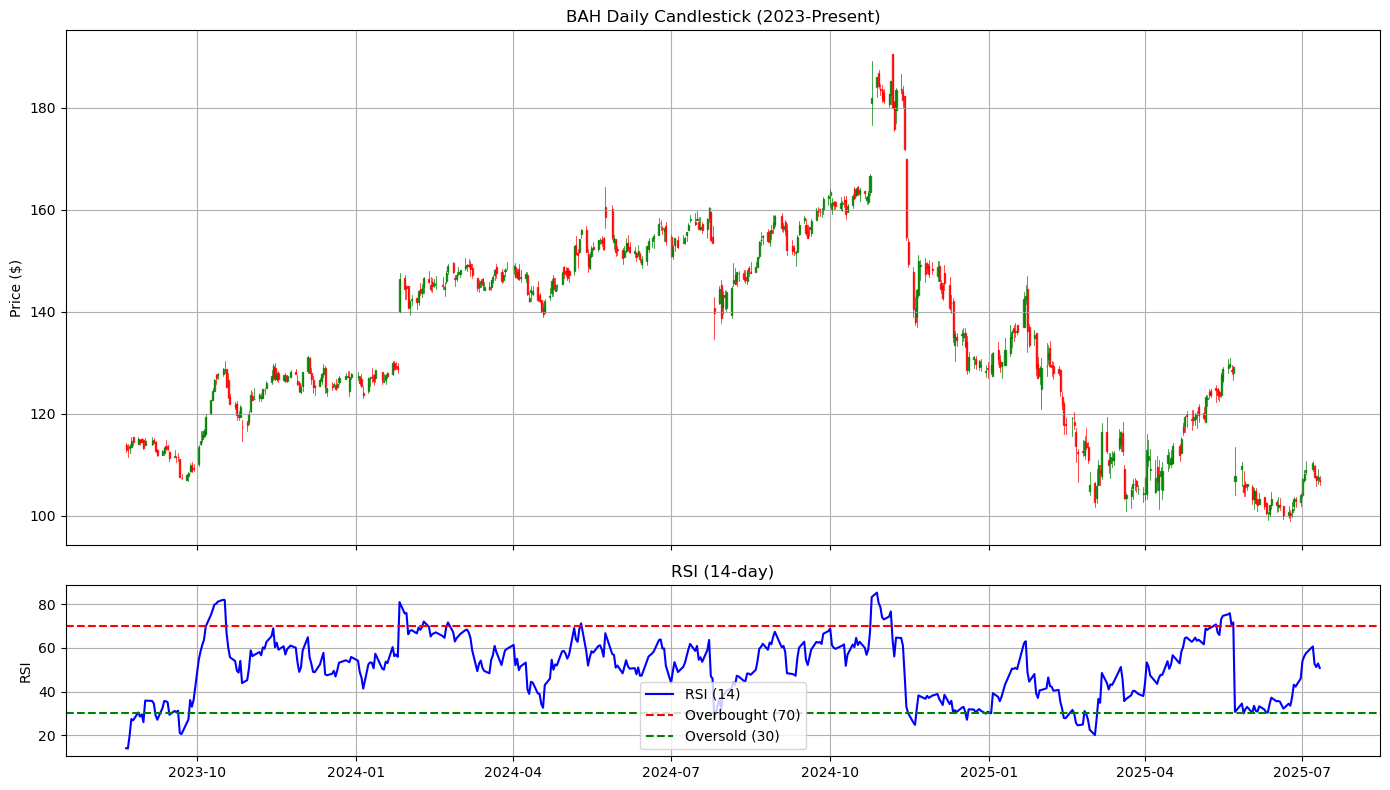

Raw OHLCV Descriptive Stats:
             open        high         low       close        volume  \
count  474.000000  474.000000  474.000000  474.000000  4.740000e+02   
mean   134.917025  136.438855  133.307849  134.853101  1.274599e+06   
std     19.729770   19.622629   19.548765   19.460151  1.112479e+06   
min     99.970000  100.760000   98.950000   99.970000  1.612970e+05   
25%    118.872500  120.495000  117.112500  119.307500  5.629762e+05   
50%    133.760000  135.800000  130.055000  132.920000  8.392025e+05   
75%    149.325000  150.815000  148.312500  149.347500  1.667193e+06   
max    190.470000  190.590000  183.900000  186.000000  9.497200e+06   

            rsi14  
count  474.000000  
mean    50.734797  
std     13.882215  
min     13.875138  
25%     39.038600  
50%     52.106699  
75%     60.758748  
max     85.386542  


In [55]:
print("Candlestick + RSI chart …")
bah["rsi14"] = RSIIndicator(bah["close"], window=14).rsi()
bah.dropna(inplace=True)
print(f"Average RSI (14) since {START_DATE}: {bah['rsi14'].mean():.2f}")

ohlc = bah.reset_index()[["date","open","high","low","close"]]
ohlc["date"] = ohlc["date"].map(mdates.date2num)
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(14,8),sharex=True,gridspec_kw={"height_ratios":[3,1]})
candlestick_ohlc(ax1, ohlc.values, width=0.6, colorup='g', colordown='r', alpha=0.8)
ax1.set_title("BAH Daily Candlestick (2023-Present)"); ax1.set_ylabel("Price ($)"); ax1.xaxis_date(); ax1.grid(True)
ax2.plot(bah.index,bah["rsi14"],color="blue",label="RSI (14)")
ax2.axhline(70,color='red',ls='--',label='Overbought (70)')
ax2.axhline(30,color='green',ls='--',label='Oversold (30)')
ax2.set_ylabel("RSI"); ax2.set_title("RSI (14-day)"); ax2.grid(True); ax2.legend()
plt.tight_layout(); plt.show()

print("Raw OHLCV Descriptive Stats:"); print(bah.describe())


In [41]:
avg_rsi = bah["rsi14"].mean()
print(f"Average RSI (14-day) since {START_DATE}: {avg_rsi:.2f}")

Average RSI (14-day) since 2023-01-01: 51.54


## Feature Engineering

In [42]:
features = pd.DataFrame(index=bah.index)

s = bah["close"]
features["ret_1m"]          = s.pct_change(WINDOW_SHORT)
features["vol_1m"]          = s.pct_change().rolling(WINDOW_SHORT).std()
features["momentum_3m"]     = s.pct_change(WINDOW_MED)
features["price_to_high_1y"]= s / s.rolling(WINDOW_LONG).max()
features["drawdown_1y"]     = s / s.cummax() - 1
features["rsi14"]           = bah["rsi14"]
features["macd"]            = MACD(s).macd_diff()
bb = BollingerBands(s)
features["bb_pct"]          = (s - bb.bollinger_lband()) / (bb.bollinger_hband() - bb.bollinger_lband())
features.dropna(inplace=True)

In [43]:
future_ret = s.shift(-5) / s - 1
labels = (future_ret > 0).astype(int).loc[features.index]
mask = labels.notna()
X_all, y_all = features[mask], labels[mask]

## Feature Selection


📊 Descriptive Stats (Selected Features):
           ret_1m  momentum_3m  price_to_high_1y       rsi14        macd  \
count  236.000000   236.000000        236.000000  236.000000  236.000000   
mean    -0.027506    -0.071079          0.748126   47.990198   -0.005193   
std      0.108207     0.135357          0.162911   14.314229    1.292755   
min     -0.263959    -0.357252          0.537473   20.049376   -5.636242   
25%     -0.116544    -0.179258          0.600497   35.612405   -0.399561   
50%     -0.017551    -0.062978          0.697151   47.231327    0.128896   
75%      0.056008     0.008677          0.941185   60.558637    0.821002   
max      0.158778     0.339865          1.000000   85.386542    2.290075   

           bb_pct  
count  236.000000  
mean     0.521363  
std      0.349305  
min     -0.254074  
25%      0.230896  
50%      0.485170  
75%      0.825765  
max      1.523956  
Correlation Matrix (Selected):


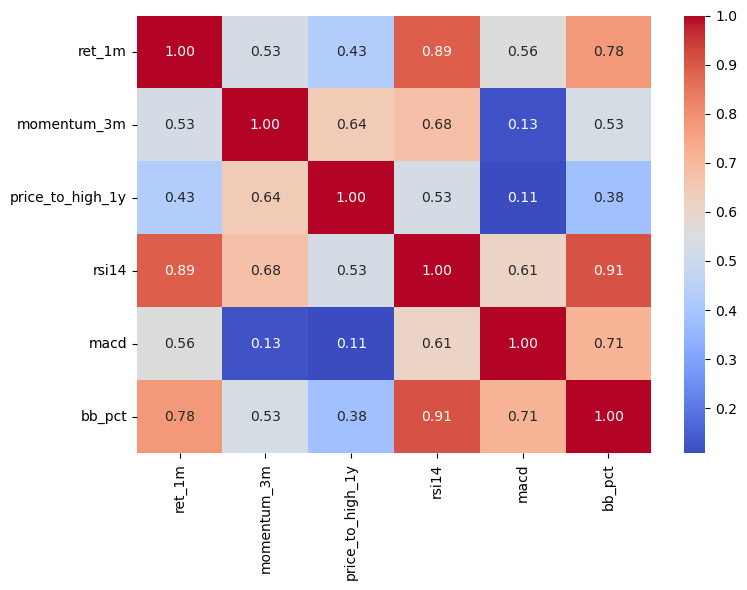

In [44]:
selector = VarianceThreshold(1e-4)
X_var = pd.DataFrame(selector.fit_transform(X_all), index=X_all.index, columns=X_all.columns[selector.get_support()])
corr_matrix = X_var.corr().abs(); upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
keep = [c for c in upper.columns if not any(upper[c] > 0.95)]; X_sel = X_var[keep]
print("\n📊 Descriptive Stats (Selected Features):"); print(X_sel.describe())

# Correlation & variance visuals
print("Correlation Matrix (Selected):")
plt.figure(figsize=(8,6)); sns.heatmap(X_sel.corr(), cmap="coolwarm", annot=True, fmt=".2f"); plt.tight_layout(); plt.show()

## Split Train/Test

In [45]:
N = len(X_sel); split = int((1-TEST_SIZE)*N)
X_train, X_test = X_sel.iloc[:split], X_sel.iloc[split:]
y_train, y_test = y_all.iloc[:split], y_all.iloc[split:]

# Upsample if classes imbalanced
from sklearn.utils import resample
if y_train.value_counts().min() < y_train.value_counts().max():
    y_train.name = "target"
    train_df = pd.concat([X_train, y_train], axis=1)
    df_major = train_df[train_df["target"]==0]
    df_minor = train_df[train_df["target"]==1]
    if len(df_minor)>0:
        df_minor_up = resample(df_minor, replace=True, n_samples=len(df_major), random_state=42)
        train_df = pd.concat([df_major, df_minor_up]).sample(frac=1, random_state=42)
        X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
        print("Applied upsampling to balance classes.")
    else:
        print("No BUY samples in training set; model may struggle.")

Applied upsampling to balance classes.


## Model & Hypertuning

In [46]:
scale_pos = (y_train==0).sum() / max((y_train==1).sum(),1)
model = XGBClassifier(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric='logloss', random_state=42,
    use_label_encoder=False, scale_pos_weight=scale_pos
)
print("Training XGBoost …")
model.fit(X_train, y_train)

Training XGBoost …


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

Test Accuracy: 0.7291666666666666
              precision    recall  f1-score   support

           0      0.882     0.577     0.698        26
           1      0.645     0.909     0.755        22

    accuracy                          0.729        48
   macro avg      0.764     0.743     0.726        48
weighted avg      0.774     0.729     0.724        48



In [48]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

scale_pos = (y_train==0).sum() / max((y_train==1).sum(), 1)
base_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos,
)

print("Hyperparameter tuning for XGBoost …")
search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_grid,
    n_iter=40,
    cv=tscv,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)
print(f"Best XGB params: {search.best_params_}")
print(f"Best CV accuracy: {search.best_score_:.3f}")

model = search.best_estimator_

y_pred = model.predict(X_test)
print("Test Accuracy (XGB tuned):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

Hyperparameter tuning for XGBoost …
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best XGB params: {'subsample': 0.6, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best CV accuracy: 0.778
Test Accuracy (XGB tuned): 0.75
              precision    recall  f1-score   support

           0      0.938     0.577     0.714        26
           1      0.656     0.955     0.778        22

    accuracy                          0.750        48
   macro avg      0.797     0.766     0.746        48
weighted avg      0.809     0.750     0.743        48



Confusion Matrix:
 [[15 11]
 [ 1 21]]


<Figure size 500x400 with 0 Axes>

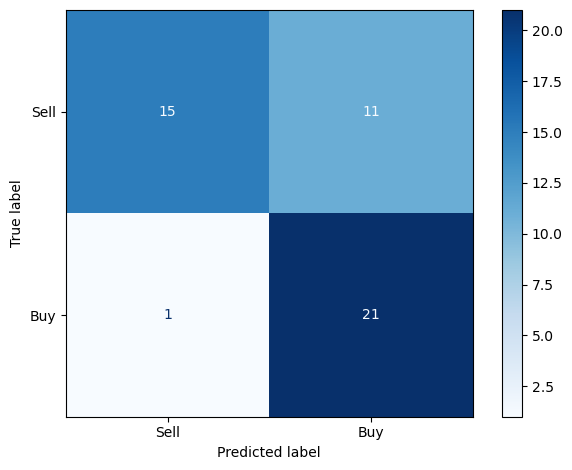

In [49]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(5,4)); ConfusionMatrixDisplay(cm, display_labels=["Sell","Buy"]).plot(cmap="Blues",values_format='d'); plt.tight_layout(); plt.show()

Feature Importances:
price_to_high_1y    0.204570
momentum_3m         0.179198
macd                0.178207
ret_1m              0.154428
rsi14               0.149344
bb_pct              0.134253
dtype: float32


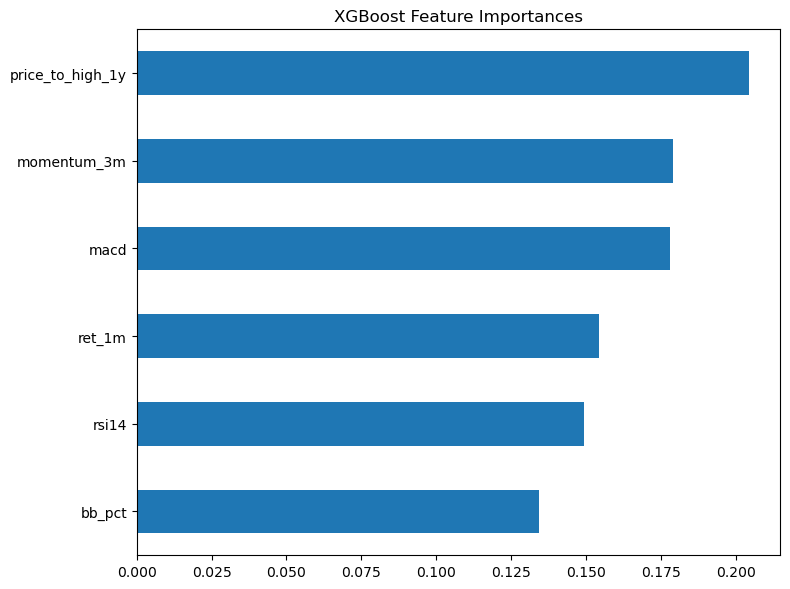

Pipeline complete.


3475

In [50]:
import gc
importances = pd.Series(model.feature_importances_, index=X_sel.columns).sort_values(ascending=False)
print("Feature Importances:"); print(importances)
plt.figure(figsize=(8,6)); importances.sort_values().plot(kind='barh'); plt.title("XGBoost Feature Importances"); plt.tight_layout(); plt.show()

print("Pipeline complete.")
gc.collect()

## Model Accuracy & Predictions against Buy-Hold

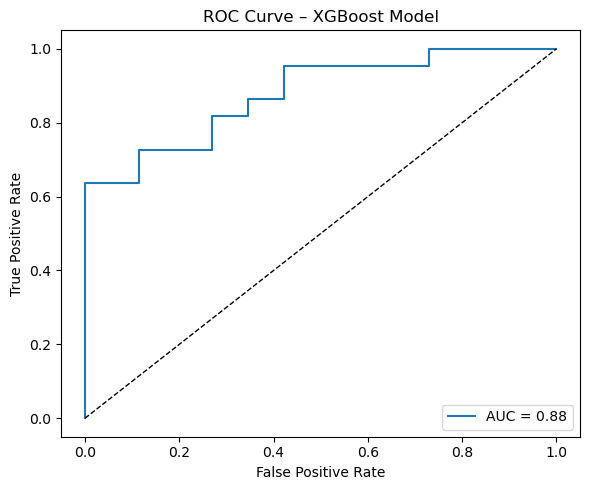

In [51]:
from sklearn.metrics import roc_curve, auc
probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

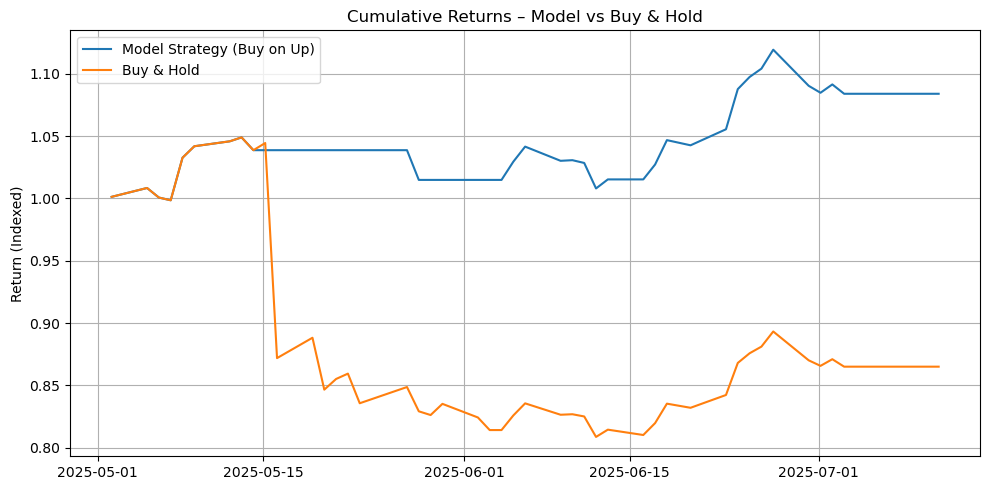

In [52]:
# Compute returns on the same rows used for testing
returns = s.pct_change().shift(-5).loc[X_test.index]

# Create strategy series: only apply return if model says BUY (1)
strategy_returns = returns.copy()
strategy_returns[y_pred == 0] = 0  # only keep return when model says 'buy'

# Cumulative returns
cumulative_model = (1 + strategy_returns.fillna(0)).cumprod()
cumulative_benchmark = (1 + returns.fillna(0)).cumprod()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cumulative_model, label="Model Strategy (Buy on Up)")
plt.plot(cumulative_benchmark, label="Buy & Hold")
plt.title("Cumulative Returns – Model vs Buy & Hold")
plt.ylabel("Return (Indexed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
strategy_daily = strategy_returns.fillna(0)
benchmark_daily = returns.fillna(0)

In [54]:
def sharpe_ratio(returns):
    return np.sqrt(252) * returns.mean() / returns.std()

sharpe_model = sharpe_ratio(strategy_daily)
sharpe_benchmark = sharpe_ratio(benchmark_daily)

print(f"Sharpe Ratio – Model Strategy: {sharpe_model:.2f}")
print(f"Sharpe Ratio – Buy & Hold:     {sharpe_benchmark:.2f}")

print("Raw OHLCV Descriptive Stats:"); print(bah.describe())

Sharpe Ratio – Model Strategy: 2.56
Sharpe Ratio – Buy & Hold:     -1.47
Raw OHLCV Descriptive Stats:
             open        high         low       close        volume  \
count  487.000000  487.000000  487.000000  487.000000  4.870000e+02   
mean   134.561376  136.061912  132.958773  134.480267  1.264249e+06   
std     19.586197   19.496101   19.405986   19.336452  1.099808e+06   
min     99.970000  100.760000   98.950000   99.970000  1.612970e+05   
25%    119.095000  120.510000  117.355000  119.370000  5.645565e+05   
50%    130.830000  133.540000  128.870000  130.740000  8.346040e+05   
75%    149.040000  150.400000  147.840000  149.060000  1.650410e+06   
max    190.470000  190.590000  183.900000  186.000000  9.497200e+06   

            rsi14  
count  487.000000  
mean    51.542626  
std     13.333846  
min     20.049376  
25%     40.704955  
50%     52.431385  
75%     61.000666  
max     85.386542  
